## Initialize Value Class

In [2]:
import math
from random import uniform

class Value:
    def __init__(self, data, _op='', _children=(), label='', grad=0):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.grad = grad
        self.label = label
        self._backward = lambda: None

    def __repr__(self):
        out = f"Value({self.data})"
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data+other.data, _op='+', _children=(self, other,))

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data, _op='*', _children=(self, other,))

        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return self*other
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, _children=(self,), _op='tanh')

        def _backward():
            self.grad += 1-t**2
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

## Define Graphing Function

In [1]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(
            name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape="record")
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2))+n2._op)
    return dot

## Test


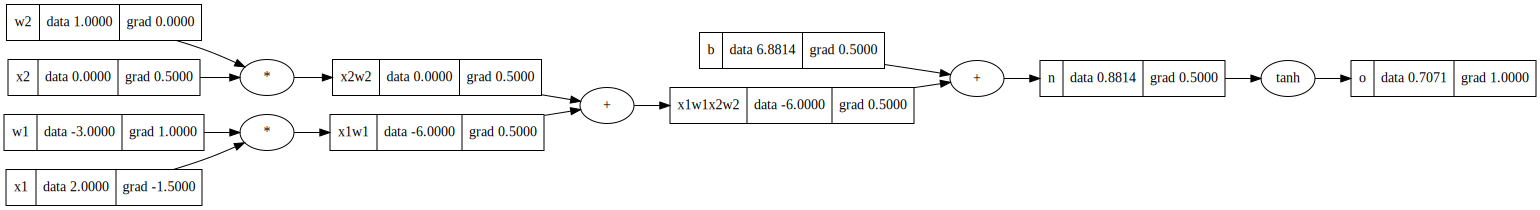

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2+b
n.label = 'n'
o = n.tanh()
o.label = 'o'
o.backward()
draw(o)

## Pytorch Implementation

In [3]:
import torch
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
i = x1*w1 + x2*w2 + b
o = torch.tanh(i)
print(o.data.item())
o.backward()
print('x1, ', x1.grad.item())
print('x2, ', x2.grad.item())
print('w1, ', w1.grad.item())
print('w2, ', w2.grad.item())
print('b, ', b.grad.item())

0.7071066904050358
x1,  -1.5000003851533106
x2,  0.5000001283844369
w1,  1.0000002567688737
w2,  0.0
b,  0.5000001283844369


/tmp/ipykernel_8768/2562664302.py:2: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  x1 = torch.Tensor([2.0]).double()


## Neural Net Library Implementation

In [4]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(-0.6589752556816736)

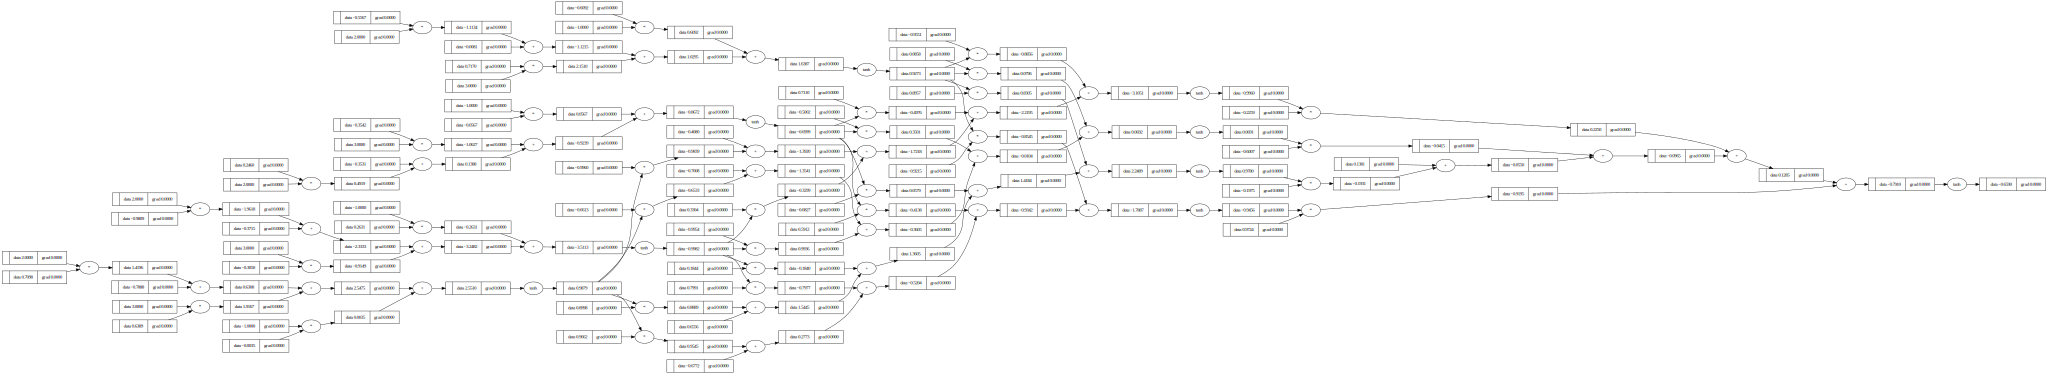

In [5]:
draw(n(x))

In [6]:
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [1.0,1.0,-1.0],
]
ys = [1.0,-1.0,-1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(-0.6589752556816736),
 Value(0.6353430092288418),
 Value(-0.684015526911201)]